# BOW model and Naive Bayes

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents
* [BOW model and Naive Bayes](#BOW-model-and-Naive-Bayes)
	* [Rotten Tomatoes data set](#Rotten-Tomatoes-data-set)
		* [Explore](#Explore)
	* [The Vector space model and a search engine.](#The-Vector-space-model-and-a-search-engine.)
		* [In Code](#In-Code)
	* [Naive Bayes](#Naive-Bayes)
		* [Cross-Validation and hyper-parameter fitting](#Cross-Validation-and-hyper-parameter-fitting)
		* [Work with the best params](#Work-with-the-best-params)
	* [Interpretation](#Interpretation)
	* [Callibration](#Callibration)
	* [To improve:](#To-improve:)


## Rotten Tomatoes data set

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print ("Number of reviews: %i" % n_reviews)
print ("Number of critics: %i" % n_critics)
print ("Number of movies:  %i" % n_movies)

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


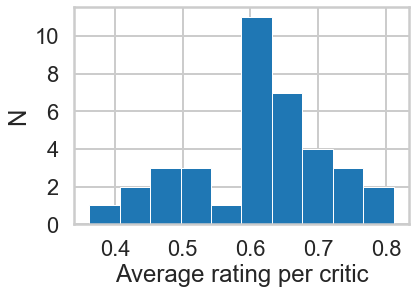

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10]);

## The Vector space model and a search engine.

All the diagrams here are snipped from
See http://nlp.stanford.edu/IR-book/ which is a great resource on Text processing.

Also check out Python packages nltk, spacy, and pattern, and their associated resources.

Let us define the vector derived from document d by $\bar V(d)$. What does this mean? Each document is considered to be a vector made up from a vocabulary, where there is one axis for each term in the vocabulary.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Then the document

"hello world world"

would be indexed as

`[(5,1),(99,2)]`

along with a dictionary

``
5: Hello
99: World
``

so that you can see that our representation is one of a sparse array.

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays and columns "being" the features, ie the vocabulary. I put "being" in quites as the layout in memort is that of a matrix with many 0's, but, rather, we use the sparse representation we talked about above.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, jealous and jealousy after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all deoends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

This we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print ("Original text is\n", '\n'.join(text), sep="")

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x

print ("Words for each feature:")
print (vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop
Transformed text vector is 
 [[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]
Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

This discussion follows that of HW3 in 2013's cs109 class.

$$P(c|d) \propto P(d|c) P(c) $$

$$P(d|c)  = \prod_k P(t_k | c) $$

the conditional independence assumption.

Then we see that for which c is $P(c|d)$ higher.

For floating point underflow we change the product into a sum by going into log space. So:

$$log(P(d|c))  = \sum_k log (P(t_k | c)) $$

But we must also handle non-existent terms, we cant have 0's for them:

$$P(t_k|c) = \frac{N_{kc}+\alpha}{N_c+\alpha N_{feat}}$$

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print ("MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest)))


MN Accuracy: 77.49%


In [8]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Accuracy on training data: %0.2f" % (training_accuracy))
print ("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.92
Accuracy on test data:     0.77


Clearly this is an overfit classifier.

### Cross-Validation and hyper-parameter fitting

We use `KFold` instead of `GridSearchCV` here as we will want to also set parameters in the CountVectorizer.

In [9]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    fold = KFold(nfold,shuffle=False, random_state=42) #new
    #for train, test in KFold(y.size, nfold, random_state=42): # split data into train/test groups, 5 times
    for train, test in fold.split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here. Remember how in HW3 we were able to set different scores in `do_classify`. We do the same thing explicitly here in `scorefunc`. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

Since Naive Bayes classifiers are often used in asymmetric situations, it might help to actually maximize probability on the validation folds rather than just accuracy.

Notice something else about using a custom score function. It allows us to do a lot of the choices with the Decision risk we care about (-profit for example) directly on the validation set, rather than comparing ROC curves on the test set as we did in HW3. You will often find people using `roc_auc`, precision, recall, or `F1-score` as risks or scores.

In [10]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$ and the `min_df` of the `CountVectorizer`.

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

Lets set up the train and test masks first:

In [11]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask=np.ones(critics.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [12]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
D:\Users\Marcelo\Ana

In [13]:
print ("alpha: %f" % best_alpha)
print ("min_df: %f" % best_min_df)

alpha: 5.000000
min_df: 0.001000


### Work with the best params

In [14]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print ("Accuracy on training data: %0.2f" % (training_accuracy))
print ("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.79
Accuracy on test data:     0.74


We might be less accurate bit we are certainly not overfit.

In [15]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(ytest, clf.predict(xtest)))

[[1160  715]
 [ 508 2286]]


## Interpretation

What are the strongly predictive features?

In [16]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print ("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print ("%20s" % w, "%0.2f" % (1 - np.exp(p)))
    
print ("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print ("%20s" % w, "%0.2f" % (1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.90
         masterpiece 0.89
            touching 0.88
              moving 0.88
            stunning 0.88
         performance 0.87
         intelligent 0.87
             perfect 0.86
                rare 0.86
        entertaining 0.86
Bad words	     P(fresh | word)
       disappointing 0.23
            tiresome 0.22
             muddled 0.22
          uninspired 0.21
               bland 0.20
           pointless 0.19
             unfunny 0.18
                lame 0.18
                dull 0.16
       unfortunately 0.15


We can see mis-predictions as well.

In [17]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [18]:
critics[y == 0].quote

30       A gloomy special-effects extravaganza filled w...
37                                  Mediocre, regrettably.
40       The movie is too pat and practiced to really b...
47       Never escapes the queasy aura of Melrose Place...
49       You want the movie to stomp and rejoice and cr...
                               ...                        
27580    ... the umpteenth prison drama to focus on the...
27593    Mr. Peckinpah's least interesting, least perso...
27595    George Cukor directed, a little impersonally f...
27598    Belying the lightheartedness of its title, Bir...
27603    We can't recommend this little item as a sampl...
Name: quote, Length: 6079, dtype: object

In [20]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print ("Mis-predicted Rotten quotes")
print ('---------------------------')
for row in bad_rotten:
    print (critics[y == 0].quote.iloc[row])
    #print

print ("Mis-predicted Fresh quotes")
print ('--------------------------')
for row in bad_fresh:
    print (critics[y == 1].quote.iloc[row])
    #print

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.
Irons gives an excruciating performance - what Streep's genuinely warm, wonderful Clara sees in him you'd need ESP to fathom.
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.
Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.
Mis-predicted Fresh quotes
--------------------------
This tough-to-peg whodunit keeps you going for 

In [21]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[0.01608144, 0.98391856]])

## Callibration

Probabilistic models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the predict_proba and predict_log_proba methods of MultinomialNB compute these probabilities.

You should always assess whether these probabilities are calibrated -- that is, whether a prediction made with a confidence of x% is correct approximately x% of the time.

Let's make a plot to assess model calibration. Schematically, we want something like this:

![callibration](callibration.png)

In words, we want to:

- Take a collection of examples, and compute the freshness probability for each using clf.predict_proba
- Gather examples into bins of similar freshness probability (the diagram shows 5 groups -- you should use something closer to 20)
- For each bin, count the number of examples in that bin, and compute the fraction of examples in the bin which are fresh
- In the upper plot, graph the expected P(Fresh) (x axis) and observed freshness fraction (Y axis). Estimate the uncertainty in observed freshness fraction F via the equation 

$$\sigma = \sqrt{\frac{F(1-F)}{N}}$$

- Overplot the line y=x. This is the trend we would expect if the model is perfectly calibrated
- In the lower plot, show the number of examples in each bin

In [22]:
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    
#your code here

def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Fresh)")
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Fresh)")
    plt.ylabel("Number")

TypeError: bar() missing 1 required positional argument: 'x'

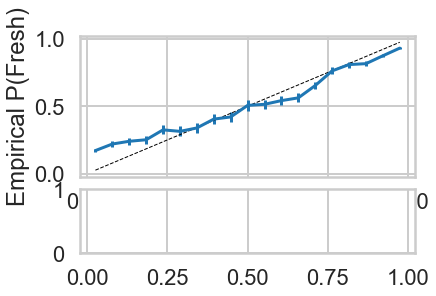

In [23]:
calibration_plot(clf, xtest, ytest)

The model is still slightly over-confident when making low P(Fresh) predictions. However, the calibration plot shows the model is usually within 1 error bar of the expected performance where P(Fresh) >= 0.2. Finally, the model makes less-conclusive predictions on average -- the histogram in the calibration plot is more uniformly distributed, with fewer predictions clustered around P(Fresh) = 0 or 1.

To think about/play with: What would happen if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?

## To improve:

There are many things worth trying. Some examples:

- You could try to build a NB model where the features are word pairs instead of words. This would be smart enough to realize that "not good" and "so good" mean very different things. This technique doesn't scale very well, since these features are much more sparse (and hence harder to detect repeatable patterns within).
- You could try a model besides NB, that would allow for interactions between words -- for example, a Random Forest classifier.
- You could consider adding supplemental features -- information about genre, director, cast, etc.
- You could build a visualization that prints word reviews, and visually encodes each word with size or color to indicate how that word contributes to P(Fresh). For example, really bad words could show up as big and red, good words as big and green, common words as small and grey, etc.

### Better features

We could use TF-IDF instead. What is this? It stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weigh this term frequency by the inverse of its popularity in all document. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. By weighing its counts by 1 divides by its overall frequency, we down-weight it. We can then use this tfidf weighted features as inputs to any classifier.

In [24]:
#http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
#http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [25]:
Xtfidf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [26]:
Xtfidf.shape

(15561, 22125)

## Clustering

We can do an unsupervized learning analysis of text as well. Algorithms like LDA are especially good for this purpose. we use the gensim library for this purpose. 

Install it with conda, not with pip.

`$ conda install gensim`

on the command line.

In [27]:
import gensim

D:\Users\Marcelo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [28]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X=vectorizer.fit_transform(critics.quote)

In [29]:
corpus=vectorizer.get_feature_names()
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.items())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [30]:
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=5, update_every=1, chunksize=1000, passes=1)

In [31]:
lda.print_topics()

[(0,
  '0.017*"movie" + 0.015*"film" + 0.007*"just" + 0.006*"good" + 0.005*"like" + 0.005*"new" + 0.005*"bad" + 0.004*"story" + 0.004*"comedy" + 0.004*"time"'),
 (1,
  '0.008*"movie" + 0.008*"film" + 0.007*"director" + 0.005*"dialogue" + 0.005*"character" + 0.003*"story" + 0.003*"picture" + 0.003*"best" + 0.003*"musical" + 0.003*"make"'),
 (2,
  '0.019*"movie" + 0.019*"film" + 0.010*"like" + 0.007*"best" + 0.005*"movies" + 0.005*"time" + 0.004*"good" + 0.004*"entertaining" + 0.004*"make" + 0.004*"does"'),
 (3,
  '0.005*"film" + 0.004*"performances" + 0.004*"direction" + 0.004*"movie" + 0.003*"characters" + 0.003*"way" + 0.003*"comedy" + 0.003*"cast" + 0.003*"horror" + 0.003*"script"'),
 (4,
  '0.014*"movie" + 0.014*"film" + 0.007*"funny" + 0.006*"comedy" + 0.004*"good" + 0.004*"man" + 0.003*"director" + 0.003*"just" + 0.003*"kind" + 0.003*"worth"')]

We can see how each document fits in with the topics. You will see this in the homework.

### Generative Models redux.

LDA is a generative model.

When we talked about generative models earlier, we said that we'd need to model P(x|y), the features belonging to one class. And in general, we might want to model the input feature distribution P(x). How do we solve either of these problems? These fall under the rubric of density estimation.

### Density estimation and Unsupervized learning

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

The basic idea in unsupervised learning is to find a compact representation of the data $\{\v{x}_1, \v{x}_2, ..., \v{x}_n\}$, whether these $\v{x}$ come from a class conditional probability distribution like those for males or females, or from all the samples. In other words, we are trying to *estimate a feature distribution* in one case or the other. This is, of course the fundamental problem of statistics, the estimation of probability distributions from data. 

We saw an example of this where we used the maximum likelihood method in logistic regression. There we were trying to estimate $P(y|\v{x}, \v{w})$, a 1-D distribution in y, by finding the most appropriate parameters $\v{w}$. Here we are trying to find some parametrization $\theta_y$ for $P(x|y, \theta_y)$ or $\v{\theta}$ in general for $P(x)$. 

But the basic method we will use remains the same: find the maximum likelihood, or, choose some probability distributions with parameters $\v{\theta}$, find the probability of each point of data if the data had come from this distribution, multiply these probabilities, and maximize the whole thing with respect to the parameters. (Equivalently we minimize the risk defined as the negative of the log-likelihood). 

Consider our heights and weights problem again. Suppose I did not tell you the labels: ie which samples were males and which samples were females. The data would then look like this:

In [32]:
df=pd.read_csv("https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


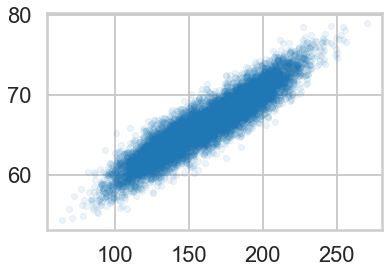

In [33]:
plt.plot(df.Weight, df.Height, '.', alpha=0.08);

The data looks vaguely elliptical and has two "clusters". Besides we know that heights and weights have normal distributions associated with them. So we decide to fit these features, with no knowledge of labels, with a mixture of two 2-D normal distributions. 

$$P(x) = \lambda G_0(\v{x},\theta_0) + (1 - \lambda) G_1(\v{x},\theta_1) $$

What we are doing is a probability distribution estimation on these height and weight features, by fitting for the parameters of whats known as a "mixture of gaussians". Note these are not the per label gaussians we fit before in LDA: rather, there are no labels any more, so this is just a mixture of gaussians. This is just a density estimation.

At this point, you may object, saying that we know from generative classifiers that we can find $P(x)$ as:

$$P(x) = \sum_y P(x|y, \theta_y) P(y).$$

You are right, if you knew the labels. But remember, I have taken these labels away from you, and thus there are no $y$'s, and this formula does not hold any more.

But your objection also makes sense: why not right the input density $P(x)$ as a sum of components, each of which is some other probability distribution. This is the notion of **clustering**: an attempt to find hidden structure in the data. So we can always write:

$$P(x) = \sum_z \lambda_z P(x|z, \theta_z),$$

where $z$ is some **hidden** variable which indexes the number of clusters in our problem. This is a variant of the idea behind the famous **kmeans** clustering algorithm, which we shall encounter in class.

So thats what we do below here, using two clusters based on our visual reconnoiter of the density in the graph above:

In [34]:
Xall=df[['Height', 'Weight']].values
from sklearn.mixture import GaussianMixture as GMM
n_clusters=2
clfgmm = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm.fit(Xall)
print (clfgmm)
gmm_means=clfgmm.means_
gmm_covar=clfgmm.covariances_
print (gmm_means, gmm_covar)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
[[ 69.12525465 187.46748275]
 [ 63.67618691 136.03917848]] [[  7.38000812  44.1825322 ]
 [ 44.1825322  369.72909388]]


How do we use these gaussians to assign clusters? Just like we did in the generative case with LDA, we can ask, which Gaussian is higher at a particular sample. We'll cluster that sample under an artificial label created by that cluster. 

We plot the results below.

In [35]:
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)

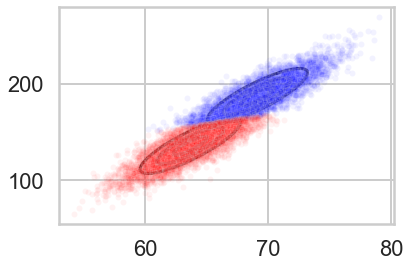

In [36]:
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
gmm_labels=clfgmm.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)

How do we know, a-priori, that two is the right number of clusters? We can try and fit a mixture of 3 gaussians

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
[[ 62.95092287 129.01243111]
 [ 70.10187845 195.96138447]
 [ 66.4592985  163.25478545]] [[  6.07590203  32.49506656]
 [ 32.49506656 264.81590898]]


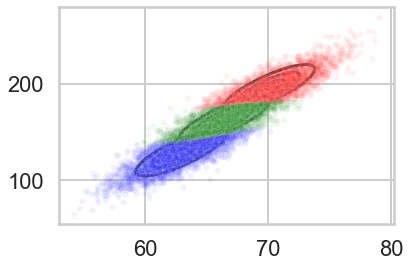

In [37]:
n_clusters=3
clfgmm3 = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm3.fit(Xall)
print (clfgmm)
gmm_means=clfgmm3.means_
gmm_covar=clfgmm3.covariances_
print (gmm_means, gmm_covar)
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[2], gmm_covar, 'k')
gmm_labels=clfgmm3.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red', 'green']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)

Which is better? Unless we have some prior knowledge, we dont know, and rely on intuition and goodness of fit estimates standard in statistics. But thinking more about how we might use prior knowledge takes us into semi-supervized learning and such, and also evaluation measures for clustering, which is not what this lab is about. 